In [1]:
import numpy as np
from time import time
import os
import sys
import scipy
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.linalg import toeplitz
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import RidgeCV

sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants

from bigbrain.brain import get_dims
from bigbrain.brain import bleaching_correction
from bigbrain.brain import z_score_brain
from bigbrain.brain import get_resolution
from bigbrain.brain import load_numpy_brain
from bigbrain.fictrac import load_fictrac
from bigbrain.fictrac import prep_fictrac
from bigbrain.utils import load_timestamps
from bigbrain.utils import sort_nicely
from bigbrain.utils import send_email
from bigbrain.glm import fit_glm
from bigbrain.glm import save_glm_map
from bigbrain.motcorr import get_motcorr_brain

In [2]:
class Fly:
    def __init__(self):
        pass
    
root_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/'

fly_folders = sorted(os.listdir(root_path))
fly_folders = [x for x in fly_folders if 'fly' in x]
sort_nicely(fly_folders)

flies = [Fly() for i in range(len(fly_folders))]

print('Created flies from folders {}'.format(fly_folders))
sys.stdout.flush()

desired_flies = [21] # 1 index
fly_folders = [fly_folders[i-1] for i in desired_flies]
flies = [flies[i-1] for i in desired_flies]
print(fly_folders)
sys.stdout.flush()

fly_idx = 0
folder = root_path + fly_folders[fly_idx]

Created flies from folders ['fly_1', 'fly_2', 'fly_3', 'fly_4', 'fly_5', 'fly_6', 'fly_7', 'fly_8', 'fly_9', 'fly_10', 'fly_11', 'fly_12', 'fly_13', 'fly_14', 'fly_15', 'fly_16', 'fly_17', 'fly_18', 'fly_19', 'fly_20', 'fly_21', 'fly_22', 'fly_23', 'fly_24', 'fly_25', 'fly_26']
['fly_21']


In [ ]:
def fit_glm(brain, dims, fictrac, beta_len):
    print('Fit GLM.')
    sys.stdout.flush()
    middle = int((beta_len - 1) / 2)
    models = []
    scores = []
    for z in range(dims['z']):
        print('~~ z:{} ~~ '.format(z), end = '')
        sys.stdout.flush()
        Y = fictrac[:,z]
        for x in range(dims['x']):
            for y in range(dims['y']):
                voxel_activity = brain[y,x,z,:]
                X = toeplitz(voxel_activity, np.zeros(beta_len))
                X = np.roll(X, middle)
                model = LassoLarsIC(criterion='bic')
                model.fit(X, Y)
                #models.append(model)
                scores.append(model.score(X,Y))
    scores = np.reshape(scores, (dims['z'], dims['x'], dims['y']))
    return scores

In [24]:
#accepts numpy fictrac
def interp_smooth_fictrac(fictrac, timestamps, columns, fps, dur):

    camera_rate = 1/fps * 1000 # camera frame rate in ms
    raw_fictrac_times = np.arange(0,dur,camera_rate)
    
    # Cut off any extra frames (only happened with brain 4)
    fictrac = fictrac[:90000]
    
    fictrac_interps = []
    
    for column in columns:
        # Smooth
        fictrac_smoothed = scipy.ndimage.filters.gaussian_filter(np.asarray(fictrac[column]),sigma=3)
        print(np.shape(fictrac_smoothed))
        # Interpolate
        # Warning: interp1d set to fill in out of bounds times
        fictrac_interp_temp = interp1d(raw_fictrac_times, fictrac_smoothed, bounds_error = False)
        fictrac_interp = fictrac_interp_temp(timestamps)

        # Replace Nans with zeros (for later code)
        np.nan_to_num(fictrac_interp, copy=False);
        
        fictrac_interps.append(fictrac_interp)
        print(np.shape(fictrac_interp))
    
    return np.asarray(fictrac_interps)

In [5]:
#accepts numpy fictrac
def fictrac_interp_object(fictrac, timestamps, columns, fps, dur):

    camera_rate = 1/fps * 1000 # camera frame rate in ms
    raw_fictrac_times = np.arange(0,dur,camera_rate)
    
    # Cut off any extra frames (only happened with brain 4)
    fictrac = fictrac[:90000]
    
    fictrac_interps = []
    
    for column in columns:
        # Smooth
        fictrac_smoothed = scipy.ndimage.filters.gaussian_filter(np.asarray(fictrac[column]),sigma=3)
        print(np.shape(fictrac_smoothed))
        # Interpolate
        # Warning: interp1d set to fill in out of bounds times
        fictrac_interp_temp = interp1d(raw_fictrac_times, fictrac_smoothed, bounds_error = False)
        #fictrac_interp = fictrac_interp_temp(timestamps)

        # Replace Nans with zeros (for later code)
        #np.nan_to_num(fictrac_interp, copy=False);
        
        fictrac_interps.append(fictrac_interp_temp)
        #print(np.shape(fictrac_interp))
    
    return fictrac_interps

In [3]:
file = os.path.join(folder, 'brain_z.nii')
brain = load_numpy_brain(file)

In [4]:
brain.shape

(128, 79, 53, 4170)

In [6]:
fps = 50 #of fictrac camera
dur = 30 * 60 * 1000 # experiment duration in ms
vols_to_clip = 200
fly_idx = 0

### Load timestamps ###
timestamps = load_timestamps(folder)

### Load fictrac (and prep) ###
fictrac = load_fictrac(root_path, fly_folders[fly_idx])
#fictrac_interp = prep_fictrac(fictrac, timestamps, fps, dur)

# remove first bit of data since it often has some weirdness
#timestamps = timestamps[vols_to_clip:,:]
#fictrac_interp = fictrac_interp[vols_to_clip:,:]

Loading timestamps.
loading timestamp data from hdf5 file... done
 load_timestamps Elapsed time: 0.0010450681050618489min
Loading fictrac.
 load_fictrac Elapsed time: 0.05204229354858399min


In [8]:
columns = ['dRotLabX', 'dRotLabY', 'dRotLabZ', 'speed']

In [9]:
fictrac_objects = fictrac_interp_object(fictrac, timestamps, columns, fps, dur)

(90000,)
(90000,)
(90000,)
(90000,)


In [10]:
fictrac_objects

In [26]:
columns = ['dRotLabX', 'dRotLabY', 'dRotLabZ', 'speed']
fictrac_new = interp_smooth_fictrac(fictrac, timestamps, columns, fps, dur)
fictrac_new = fictrac_new[:,200:,:]

(90000,)
(4370, 53)
(90000,)
(4370, 53)
(90000,)
(4370, 53)
(90000,)
(4370, 53)


In [16]:
dims = get_dims(brain)
print(dims)

{'x': 79, 'y': 128, 'z': 53, 't': 4170}


In [27]:
timestamps[:,z].shape

(4370,)

In [12]:
y = 57
x = 22
z = 11

In [183]:
# Currently interpolating fictrac from 50Hz to the voxel's 3Hz
# Now that I've switched to predicting voxel activity from behavior, don't need to remove so much fictrac data
# Lets say I make the toeplitz at 10Hz
# For each voxel timestamp, sample behavior at that time and +/- desired times

# First make timestamp matrix to use to interpolate
time_vector = timestamps[200:,z]
new_rate = 100 #in ms
pre_dur = -10001 #in ms
post_dur = 10001 #in ms

row_vector_pre = np.flip(np.arange(0,pre_dur,-new_rate),axis=0)
row_vector_post = np.arange(0,post_dur,new_rate)
row_vector = np.unique(np.concatenate((row_vector_pre, row_vector_post)))

times_for_interp = np.add.outer(timestamps[200:,z], row_vector)

fictrac_interp = fictrac_objects[-1](times_for_interp)
fictrac_interp = np.nan_to_num(fictrac_interp)

In [78]:
row_vector

array([-5000, -4900, -4800, -4700, -4600, -4500, -4400, -4300, -4200,
       -4100, -4000, -3900, -3800, -3700, -3600, -3500, -3400, -3300,
       -3200, -3100, -3000, -2900, -2800, -2700, -2600, -2500, -2400,
       -2300, -2200, -2100, -2000, -1900, -1800, -1700, -1600, -1500,
       -1400, -1300, -1200, -1100, -1000,  -900,  -800,  -700,  -600,
        -500,  -400,  -300,  -200,  -100,     0,   100,   200,   300,
         400,   500,   600,   700,   800,   900,  1000,  1100,  1200,
        1300,  1400,  1500,  1600,  1700,  1800,  1900,  2000,  2100,
        2200,  2300,  2400,  2500,  2600,  2700,  2800,  2900,  3000,
        3100,  3200,  3300,  3400,  3500,  3600,  3700,  3800,  3900,
        4000,  4100,  4200,  4300,  4400,  4500,  4600,  4700,  4800,
        4900,  5000])

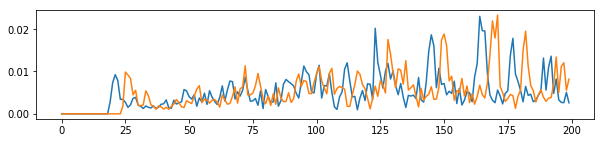

In [15]:
plt.figure(figsize=(10,2))
plt.plot(fictrac_interp[:200,100])
plt.plot(fictrac_interp[:200,0])
#plt.plot(fictrac_interp[:200,-1])
plt.show()

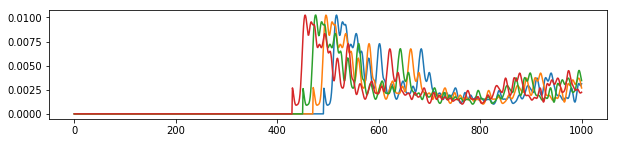

In [16]:
plt.figure(figsize=(10,2))
plt.plot(fictrac_interp[0,:])
plt.plot(fictrac_interp[1,:])
plt.plot(fictrac_interp[2,:])
plt.plot(fictrac_interp[3,:])
#plt.plot(fictrac_interp[:200,0])
#plt.plot(fictrac_interp[:200,-1])
plt.show()

In [17]:
fictrac_interp.shape

(4370, 1001)

In [149]:
times_for_interp[0,101]

82590.71712

In [148]:
timestamps[0,z]

82570.71712

In [154]:
brain.shape

(128, 79, 53, 4170)

In [31]:
fictrac_interp.shape

(4370, 1001)

In [22]:
brain.shape

(128, 79, 53, 4170)

In [212]:
y = 57
x = 22
z = 11


Y = brain[y,x,z,:]
X = fictrac_interp
model_lasso = LassoLarsIC(criterion='bic')
model_lasso.fit(X, Y)

LassoLarsIC(copy_X=True, criterion='bic', eps=2.220446049250313e-16,
      fit_intercept=True, max_iter=500, normalize=True, positive=False,
      precompute='auto', verbose=False)

In [184]:
y = 57
x = 22
z = 11

In [185]:
t0 = time()
Y = brain[y,x,z,:]
X = fictrac_interp
model_ridge = Ridge()
model_ridge.fit(X, Y)
print(time()-t0)

0.015593528747558594


In [214]:
y = 57
x = 22
z = 11

Y = brain[y,x,z,:]
X = fictrac_interp
model_elastic = ElasticNetCV()
model_elastic.fit(X, Y)

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [196]:
from sklearn.linear_model import ElasticNetCV

In [161]:
import scipy.linalg as sl

In [216]:
b = sl.lstsq(X, Y)[0]

In [172]:
model_ridge.score(X,Y)

0.08874663744681532

In [173]:
temp = model_ridge.predict(X)

In [160]:
temp.shape

(4170,)

In [218]:
models = {'least_squares': b,
          'lasso': model_lasso.coef_,
          'ridge': model_ridge.coef_,
          'elastic_net': model_elastic.coef_}

In [220]:
for i, model in enumerate(models):
    print(model)

least_squares
lasso
ridge
elastic_net


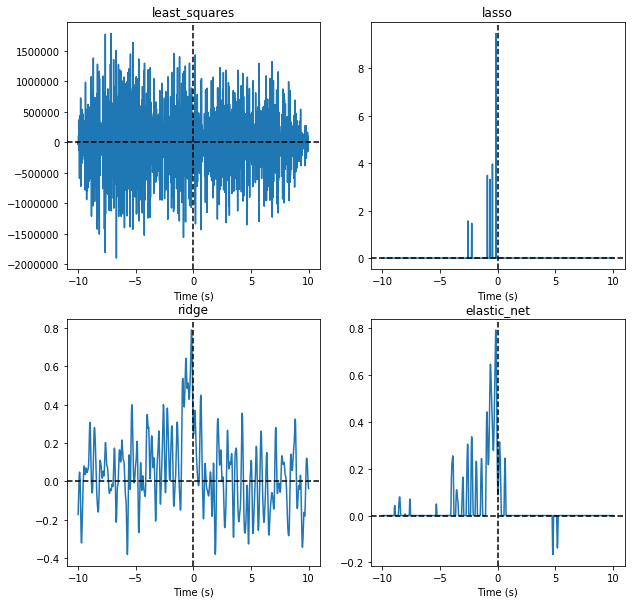

In [227]:
plt.figure(figsize=(10,10))
for i, model in enumerate(models):
    plt.subplot(2,2,i+1)
    plt.plot(row_vector/1000,models[model])
    plt.axvline(0, color='k', linestyle='--')
    plt.axhline(0, color='k', linestyle='--')
    plt.xlabel('Time (s)')
    plt.title(model)
plt.show()

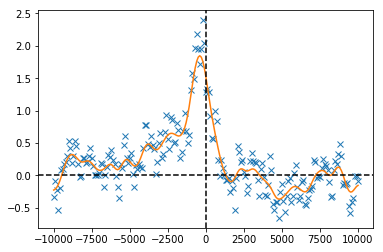

In [197]:
plt.plot(row_vector, model_ridge.coef_,'x')
smoothed_coef = scipy.ndimage.filters.gaussian_filter(model_ridge.coef_,sigma=3)
plt.plot(row_vector, smoothed_coef)
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.show()

In [166]:
out_conv_raw = np.convolve(X[:,50],model_ridge.coef_,'same')

In [171]:
model_ridge.coef_ = smoothed_coef

In [154]:
out.shape

(4170,)

In [152]:
X.shape

(4170, 101)

In [156]:
from sklearn.metrics import r2_score

In [175]:
r2_score(Y, temp) 

0.08874663744681532

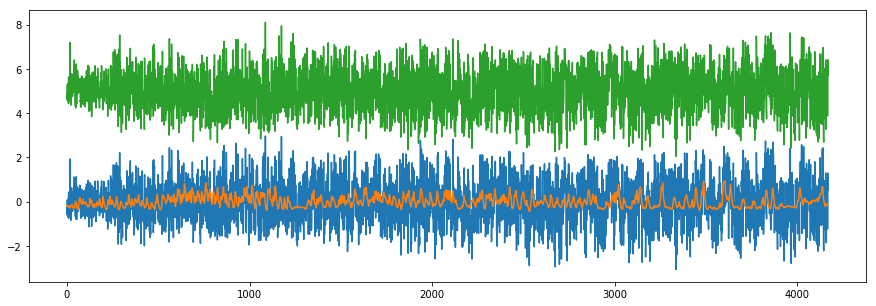

In [208]:
plt.figure(figsize=(15,5))
#plt.plot(X[:,50])
plt.plot(Y)
plt.plot(temp)
plt.plot((Y-temp)+5)
#plt.plot(out_conv_raw)
#plt.xlim(1000,1500)
plt.show()

### For a given z-slice, lets calculate the smoothed coef kernel and score for the 4 behavior parameters.

In [236]:
z = 10

# First make timestamp matrix to use to interpolate
time_vector = timestamps[200:,z]
new_rate = 100 #in ms
pre_dur = -10001 #in ms
post_dur = 10001 #in ms

row_vector_pre = np.flip(np.arange(0,pre_dur,-new_rate),axis=0)
row_vector_post = np.arange(0,post_dur,new_rate)
row_vector = np.unique(np.concatenate((row_vector_pre, row_vector_post)))

times_for_interp = np.add.outer(timestamps[200:,z], row_vector)


scores3 = []
coefs3 = []
for i in range(1):
    t0=time()
    fictrac_interp = fictrac_objects[i](times_for_interp)
    fictrac_interp = np.nan_to_num(fictrac_interp)
    X = fictrac_interp
    
    for y in range(np.shape(brain)[0]):
        print(y)
        for x in range(np.shape(brain)[1]):
            Y = brain[y,x,z,:]
            model_ridge = LassoLarsIC(criterion='bic')
            model_ridge.fit(X, Y)
            score = model_ridge.score(X,Y)
            scores3.append(score)
            coefs3.append(coefs)
    print(time()-t0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
888.0078012943268


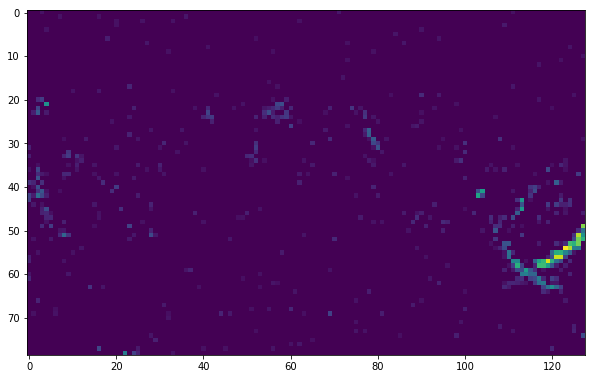

In [238]:
scores_reshaped3 = np.reshape(scores3,(np.shape(brain)[0],np.shape(brain)[1]))
plt.figure(figsize=(10,10))
plt.imshow(np.swapaxes(scores_reshaped3[:,:],0,1))
plt.show()

In [234]:
scores_reshaped2 = np.reshape(scores2,(np.shape(brain)[0],np.shape(brain)[1]))

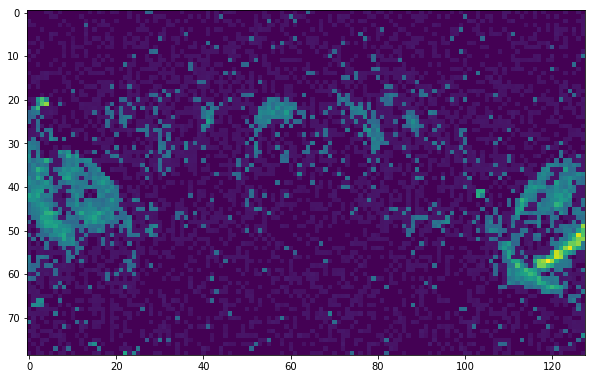

In [235]:
plt.figure(figsize=(10,10))
plt.imshow(np.swapaxes(scores_reshaped2[:,:],0,1))
plt.show()

In [214]:
scores_reshaped = np.reshape(scores,(4,np.shape(brain)[0],np.shape(brain)[1]))

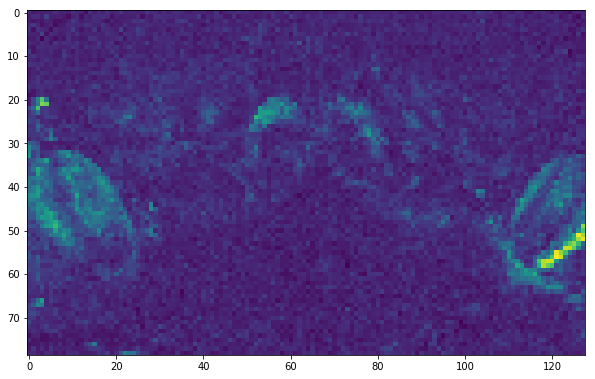

In [232]:
plt.figure(figsize=(10,10))
plt.imshow(np.swapaxes(scores_reshaped[3,:,:],0,1))
plt.show()

In [ ]:
plt.plot()

In [195]:
poly_coef = np.polyfit(row_vector, model_ridge.coef_, 20)
poly_func = np.poly1d(poly_coef)
poly = poly_func(row_vector)

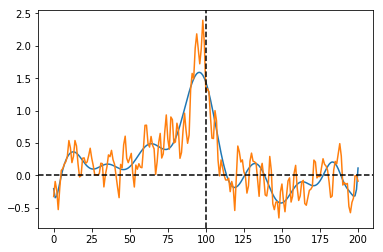

In [196]:
plt.plot(poly)
plt.plot(model_ridge.coef_)
plt.axvline(100, color='k', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.show()

In [77]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [81]:
poly_model = make_pipeline(PolynomialFeatures(4), Ridge())
poly_model.fit(np.reshape(row_vector, (-1, 1)), model_ridge.coef_)

/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.296468e-31
  overwrite_a=True).T


Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=4, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [86]:
y_plot = poly_model.predict(np.reshape(model_ridge.coef_,(-1,1)))

In [87]:
y_plot

array([0.9670287 , 0.96702643, 0.96708092, 0.96711537, 0.96706414,
       0.96707432, 0.96706399, 0.96707681, 0.96707814, 0.96702925,
       0.96697326, 0.9669763 , 0.96702447, 0.96703113, 0.96700346,
       0.96702604, 0.96703838, 0.96710066, 0.96706673, 0.96701954,
       0.96699994, 0.96706297, 0.96705084, 0.96699522, 0.96695725,
       0.96701819, 0.96704256, 0.96696107, 0.96696958, 0.96702826,
       0.96702583, 0.96697754, 0.96699394, 0.96706275, 0.96705123,
       0.96699679, 0.96695182, 0.96699343, 0.96702689, 0.96700587,
       0.96689354, 0.96685425, 0.96686898, 0.9667923 , 0.96675481,
       0.96679407, 0.96683097, 0.96679229, 0.96672139, 0.9667786 ,
       0.96689954, 0.96688991, 0.96689563, 0.96695679, 0.96701396,
       0.96701214, 0.9669442 , 0.96697117, 0.96706995, 0.96710533,
       0.96706524, 0.96708505, 0.9671069 , 0.96711595, 0.9671153 ,
       0.96711186, 0.96714684, 0.96712105, 0.96713493, 0.96719   ,
       0.96711205, 0.96703236, 0.96704479, 0.96706872, 0.96706

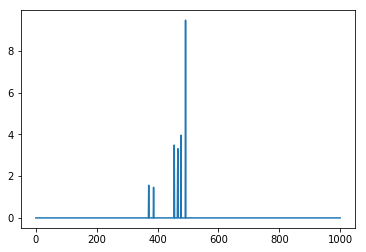

In [188]:
plt.plot(model.coef_)
plt.show()

In [103]:
Y.shape

(4170,)

In [98]:
out[0,:]

array([81565.07396, 81665.07396, 81765.07396, 81865.07396, 81965.07396,
       82065.07396, 82165.07396, 82265.07396, 82365.07396, 82465.07396,
       82565.07396, 82665.07396, 82765.07396, 82865.07396, 82965.07396,
       83065.07396, 83165.07396, 83265.07396, 83365.07396, 83465.07396,
       83565.07396])

In [85]:
row_vector_pre

array([-1000,  -900,  -800,  -700,  -600,  -500,  -400,  -300,  -200,
        -100,     0])

In [54]:
y = 57
x = 22
z = 11
beta_len = 41
middle = int((beta_len - 1) / 2)

Y = brain[y,x,z,:]
X = toeplitz(fictrac_new[-1,:,z], np.zeros(beta_len))
X = np.roll(X, middle)
model = LassoLarsIC(criterion='bic')
model.fit(X, Y)

LassoLarsIC(copy_X=True, criterion='bic', eps=2.220446049250313e-16,
      fit_intercept=True, max_iter=500, normalize=True, positive=False,
      precompute='auto', verbose=False)

In [168]:
model.score(X,Y)

0.09632807323306847

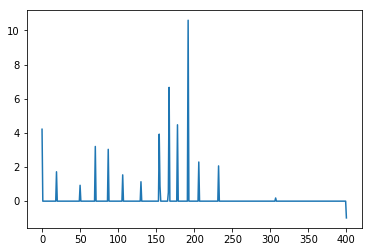

In [167]:
plt.plot(model.coef_)
plt.show()

In [46]:
timestamps = timestamps[200:,:]

In [50]:
timestamps.shape

(4170, 53)

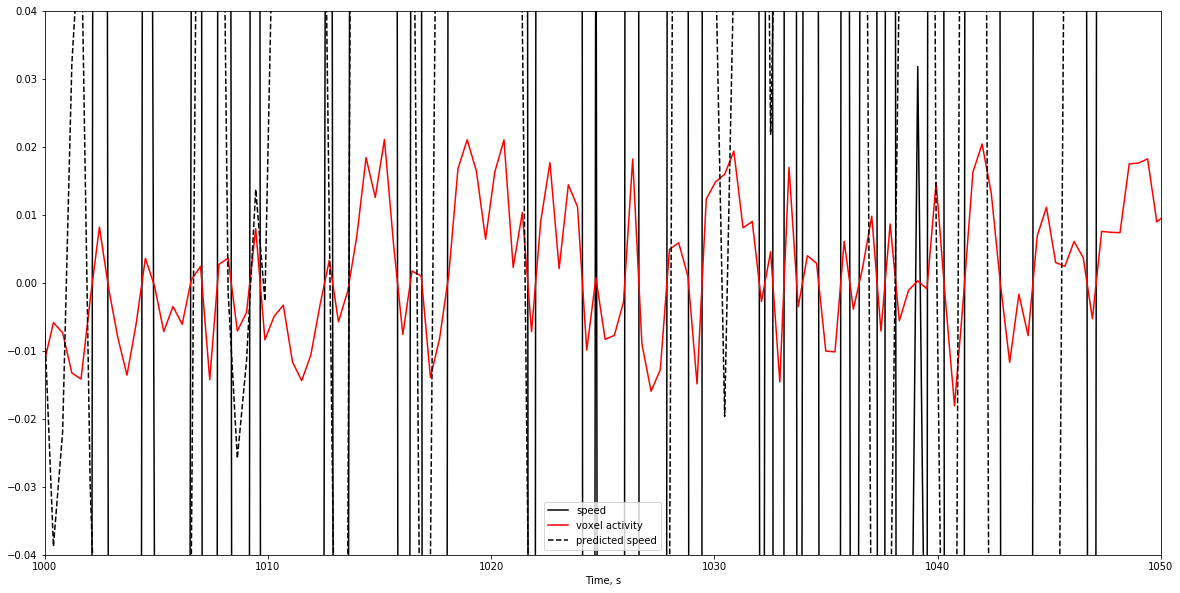

In [56]:
plt.figure(figsize=(20,10))

plt.plot(timestamps[:,z]/1000, Y, color = 'k', label = 'speed')
plt.plot(timestamps[:,z]/1000, voxel_activity/100, color = 'r', label = 'voxel activity')
plt.plot(timestamps[:,z]/1000, model.predict(X), color = 'k', linestyle='--', label = 'predicted speed')
plt.xlim(1000,1050)
plt.ylim(-0.04,.04)
plt.legend()
plt.xlabel('Time, s')
#plt.title('Period of low movement')
plt.show()

In [44]:
from sklearn.linear_model import Ridge

In [35]:
from sklearn.linear_model import LassoCV

In [159]:
reg = LassoCV(cv=5, random_state=0).fit(X, Y)

/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/share/software/user/open/py-scikit-learn/0.19

/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/share/software/user/open/py-scikit-learn/0.19

/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/share/software/user/open/py-scikit-learn/0.19